In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf
import imblearn
from sklearn.model_selection import train_test_split
import collections
from sklearn.metrics import roc_curve, auc
import pickle as pkl

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name
signal='elec'
bkg = 'PU'
savedir = workdir + '/moo/'+ bkg + '/'
os.makedirs(savedir, exist_ok=True)
name = '40gen_diag_auc_mut10_3d.pkl'

In [3]:
bkg

'PU'

In [4]:
import pymoo
pymoo.__version__

'0.4.2.2'

In [5]:
import numpy as np

#nvar
nvar = 19
print('nvar',nvar)

#nobj
nobj = 3 # efficiency and number of bits used

#nconstr
nconstr = 0

bitmin= 0 #0 if we want to remove features

# varaiables lower bound xl
xl=0
print('lower bounds',xl)

bitmax = 12
#upper bound
xu =12
print ('upper bounds',xu)

param = {
        'nthread' : 8,
        # Parameters that we are going to tune.
        'max_depth':2,
        'eta':0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Other parameters
        'objective':'binary:logistic',
        'eval_metric': 'auc', 
        'alpha':0.01,
        'lambda':10,
    }


from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling, get_selection
from pymoo.optimize import minimize
from pymoo.model.problem import Problem


class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=nvar, n_obj=nobj, n_constr=nconstr, xl=xl, xu=xu, type_var=int, elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):
        #define evaluations functions (minimization)
        #f1 = bkg eff at 99% signal efficiency
        #print(x)
        #it=pd.DataFrame([x], columns=features)
        #print(it)
        f1=1
        f2=2
        f3=3
        out["F"] = [f1, f2,f3]
problem=MyProblem()

nvar 19
lower bounds 0
upper bounds 12


In [6]:
os.listdir(savedir)

['40gen_diag_auc.pkl',
 '40gen_diag_auc.png',
 '40gen_diag_auc_cross10.pkl',
 '40gen_diag_auc_cross10.png',
 '40gen_diag_auc_cross10_lastgen.csv',
 '40gen_diag_auc_mut10.pkl',
 '40gen_diag_auc_mut10.png',
 '40gen_diag_auc_mut10_lastgen.csv',
 '40gen_diag_auc.pkl_lastgen.csv',
 '40gen_diag_auc.pkl_par.png',
 '40gen_diag_auc.pkl_par_sorted.png',
 'feats',
 '40gen_diag_auc.pkl_par_cut.png',
 '40gen_diag_auc_mut10.pkl_lastgen.csv',
 '40gen_diag_auc_mut10.pkl_par.png',
 '40gen_diag_auc_mut10.pkl_par_sorted.png',
 '40gen_diag_auc_mut10.pkl_par_cut.png',
 '40gen_diag_auc_mut10_3d.pkl',
 '40gen_diag_auc_mut10_3d.pkl_lastgen.csv',
 'convergence.html',
 'solutions.html']

In [7]:
res=pkl.load(open(savedir+name, 'rb'))
        

In [8]:
res

from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', )
if 'auc' in name:
    coeff=(-1,1,1)
    title = 'AUC > 0.8 tpr'
    ax.set_xlim(0.99, 1)
else:
    coeff= (1,1,1)
    title= 'bkg eff at 0.99 signal efficiency'
    i=0
    X,Y,Z=(res.history[i].pop.get("F")*coeff).T
    ax.scatter(X, Y, Z, label= 'gen {}'.format(i+1))
for i, hist in enumerate(res.history):
    if (i+1)%2==0:
        X,Y,Z=(res.history[i].pop.get("F")*coeff).T
        ax.scatter(X, Y, Z, label= 'gen {}'.format(i+1))
    if i > 10 :break

#plt.vlines(x=f1, ymin=30, ymax= 170, label = "unquantized")

ax.set_ylim(0,80)
ax.set_zlim(0,10000)
ax.set_xlabel(title)
ax.set_ylabel('number of bits used')
ax.set_zlabel('number of splits in model')
plt.legend()
#plt.savefig(savedir + '{}.png'.format(moo_name))

In [9]:
#try plotly to export results to html
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

# colors
palette = cycle(px.colors.qualitative.D3)

                
if 'auc' in name:
    coeff=(-1,1,1)
    title = 'AUC > 0.8 tpr'
else:
    coeff= (1,1,1)
    title= 'bkg eff at 0.99 signal efficiency'
i=0
marker_size=4
X,Y,Z=(res.history[i].pop.get("F")*coeff).T
data=[go.Scatter3d(x=X, y=Y,z=Z,
                name='gen_{}'.format(i), mode='markers',marker=dict(size=marker_size),marker_color=next(palette))]
for i, hist in enumerate(res.history):
    if (i+1)%2==0:
        X,Y,Z=(res.history[i].pop.get("F")*coeff).T
        data.append(go.Scatter3d(x=X, y=Y,z=Z,
                    name='gen_{}'.format(i), mode='markers', marker=dict(size=marker_size),marker_color=next(palette)))
    if i > 10 :break
        
        
        
fig = go.Figure(data=data)
fig.update_layout(scene = dict(
                    #xaxis_title='Efficiency (AUX > 0.8 sig efficiency)',
                    xaxis = dict(
                    title='Efficiency (AUX > 0.8 sig efficiency)',
                    tickmode = 'linear',
                    tick0 = 0.99,
                    dtick = 0.001,
                    range=[0.99, 0.999]),
                    yaxis_title='number of bits',
                    zaxis_title='number of splits'),
                    margin=dict(r=20, b=10, l=10, t=10),autosize=False,
                    width=1400,height=800,
                    legend = dict(font = dict(size=16),
                                  itemsizing= 'constant'))
fig.show()
fig.write_html(os.getcwd()+'/moo/{}/convergence.html'.format(bkg))

In [10]:
if bkg == 'QCD':
    feats= ['abseta',
 '1st lay',
 'vee',
 'vpp',
 'vzz',
 'vrr',
 'meanz',
 'sho lgth',
 'core lgth',
 'EoT' ,
 'ebm1',
 'Emx_4R',
 'rev ebm1',
 'first_2',
 'Emx_2R',
 'Emx_5']
elif bkg =='PU':
    feats = ['abseta', '1st lay', 'vee', 'vpp', 'vzz', 'vrr',
                 'meanz', 'sho lgth','core lgth', 'EoT',
                'firstH_5', 'Emx_4R', 'ebm1', 'Emx_2R', '1stH_1', 'Emx_5']
elif bkg == 'pions':
    feats = ['abseta',
 '1st lay',
 'vee',
 'vpp',
 'vzz',
 'vrr',
 'meanz',
 'sho lgth',
    'core lgth',
 'EoT',
 'Emx_5',
 'ebm1',
 'Emx_4R',
 'hbm',
 '1stH_1',
 'rev ebm1']
feats.extend(['max boost rounds', 'max depth', 'eta'])
result= pd.DataFrame(res.X, columns=feats)

a=[-100*a for (a,b,c) in res.F]
b=[int(b) for (a,b,c) in res.F]
c=[int(c) for (a,b,c) in res.F]
result['n_kept']=np.count_nonzero(result[feats[:-3]], axis=1)
result['bits']=b
result['splits'] = c
result['eff']=a
result['eta'] = float(10)**((-1)*result['eta'])
result.sort_values(["eff"])

result.to_csv(savedir + '{}_lastgen.csv'.format(name))


In [11]:
pd.set_option('display.precision', 4)

if bkg=='PU':
    auc_min = 99.5
    auc_max=99.9
    bits_min= 0
    bits_max = 60
    splits_min= 0
    splits_max= 3000
if bkg=='pions':
    auc_min = 99.6
    auc_max=99.9
    bits_min= 0
    bits_max = 35
    splits_min= 0
    splits_max= 600
if bkg=='QCD':
    auc_min = 99.7
    auc_max=99.9
    bits_min= 0
    bits_max = 55
    splits_min= 0
    splits_max= 5000
result_cut=result[(result['eff']<auc_max) & (result['eff']>= auc_min) & (result['bits']>= bits_min) & 
                   (result['bits']<bits_max)& (result['splits']>=splits_min) & (result['splits']<splits_max)]
res_bdt=result_cut[['max boost rounds', 'max depth', 'eta','n_kept','bits', 'splits','eff']]
result_cut=result_cut.reindex(result_cut[feats[:-3]].mean().sort_values().index, axis=1)
result_cut=pd.concat([result_cut, res_bdt], axis=1)
test=result_cut.sort_values('eff', ascending=False).style.background_gradient(axis=0, subset = [col for col in result_cut.columns if col not in ['bits', 'eff']])

test.background_gradient(axis=0, subset = ['n_kept','bits', 'splits','eff'], cmap='viridis')

In [12]:

# colors
palette = cycle(px.colors.qualitative.D3)

                
if 'auc' in name:
    coeff=(-1,1,1)
    title = 'AUC > 0.8 tpr'
else:
    coeff= (1,1,1)
    title= 'bkg eff at 0.99 signal efficiency'
i=0
marker_size=4

X=result_cut['eff']
Y=result_cut['bits']
Z=result_cut['splits']
data=[go.Scatter3d(x=X, y=Y,z=Z, name='gen_{}'.format(i), mode='markers',marker=dict(size=marker_size+6),marker_color=next(palette))]

X=result['eff']
Y=result['bits']
Z=result['splits']
data.append(go.Scatter3d(x=X, y=Y,z=Z,name='gen_{}'.format(i), mode='markers',
                          marker=dict(size=marker_size),marker_color=next(palette)))


        
        
fig = go.Figure(data=data)
fig.update_layout(scene = dict(
                    #xaxis_title='Efficiency (AUX > 0.8 sig efficiency)',
                    xaxis = dict(
                    title='Efficiency (AUX > 0.8 sig efficiency)',
                    tickmode = 'linear',
                    tick0 = 99,
                    dtick = 0.1,
                    range=[99, 99.9]),
                    yaxis_title='number of bits',
                    zaxis_title='number of splits'),
                    margin=dict(r=20, b=10, l=10, t=10),autosize=False,
                    width=1400,height=800,
                    legend = dict(font = dict(size=16),
                                  itemsizing= 'constant'))
fig.show()
fig.write_html(os.getcwd()+'/moo/{}/solutions.html'.format(bkg))


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.



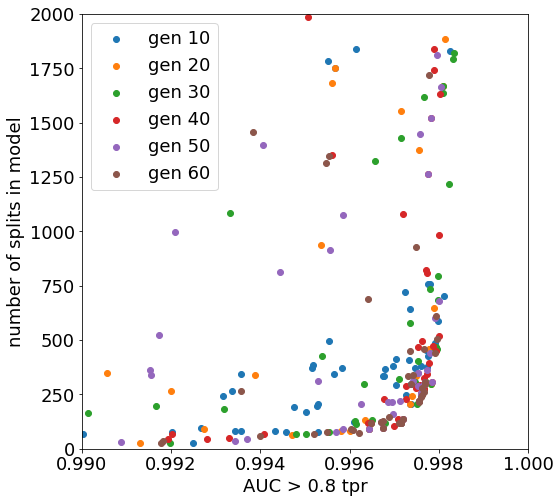

In [13]:
#plot roc curves
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
if 'auc' in name:
    coeff=(-1,1,1)
    title = 'AUC > 0.8 tpr'
    ax.set_xlim(0.99, 1)
else:
    coeff= (1,1,1)
    title= 'bkg eff at 0.99 signal efficiency'
    i=0
    X,Y,Z=(res.history[i].pop.get("F")*coeff).T
    ax.scatter(X, Z, label= 'gen {}'.format(i+1))
for i, hist in enumerate(res.history):
    if (i+1)%10==0:
        X,Y,Z=(res.history[i].pop.get("F")*coeff).T
        ax.scatter(X, Z, label= 'gen {}'.format(i+1))

#plt.vlines(x=f1, ymin=30, ymax= 170, label = "unquantized")

ax.set_ylim(0,2000)
#ax.set_zlim(0,100)
ax.set_xlabel(title)
#ax.set_ylabel('number of bits used')
ax.set_ylabel('number of splits in model')
plt.legend()

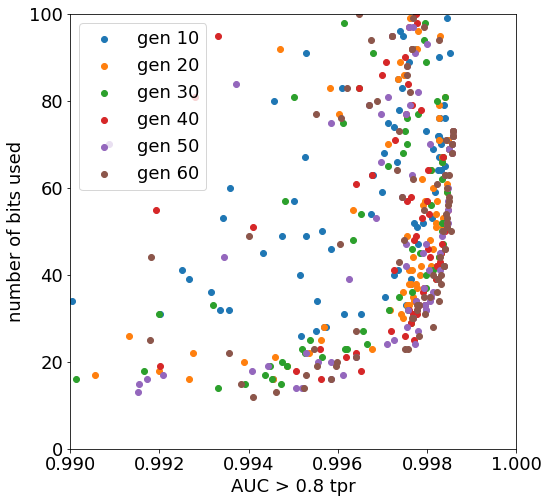

In [14]:

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
if 'auc' in name:
    coeff=(-1,1,1)
    title = 'AUC > 0.8 tpr'
    ax.set_xlim(0.99, 1)
else:
    coeff= (1,1,1)
    title= 'bkg eff at 0.99 signal efficiency'
    i=0
    X,Y,Z=(res.history[i].pop.get("F")*coeff).T
    ax.scatter(X, Y, label= 'gen {}'.format(i+1))
for i, hist in enumerate(res.history):
    if (i+1)%10==0:
        X,Y,Z=(res.history[i].pop.get("F")*coeff).T
        ax.scatter(X, Y, label= 'gen {}'.format(i+1))

#plt.vlines(x=f1, ymin=30, ymax= 170, label = "unquantized")

#ax.set_ylim(0,2000)
ax.set_ylim(0,100)
ax.set_xlabel(title)
ax.set_ylabel('number of bits used')
#ax.set_ylabel('number of splits in model')
plt.legend()

In [15]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


In [16]:
res.history[0].pop.get('F').T[0]

array([-0.90638408, -0.99356094, -0.99509935, -0.99568867, -0.99529541,
       -0.99775963, -0.99773214, -0.99588593, -0.99464169, -0.99552606,
       -0.99765936, -0.9976359 , -0.97041282, -0.99566134, -0.99724496,
       -0.99787315, -0.99807014, -0.99628972, -0.9969772 , -0.9975221 ,
       -0.99159849, -0.99384545, -0.99473016, -0.99386754, -0.99313416,
       -0.9906824 , -0.99288862, -0.99386127, -0.9976092 , -0.99449676,
       -0.99513331, -0.99528344, -0.99513851, -0.99629112, -0.9972193 ,
       -0.99671934, -0.99725958, -0.99449024, -0.99726143, -0.99741833,
       -0.99409601, -0.99619197, -0.99328724, -0.99655801, -0.99638131,
       -0.99747834, -0.9883146 , -0.99094298, -0.99102026, -0.99756268,
       -0.99503701, -0.99359132, -0.99661302, -0.99668431, -0.99422039,
       -0.9912584 , -0.99341164, -0.99593832, -0.99655829, -0.99660415,
       -0.99632922, -0.99662296, -0.99741093, -0.99694589, -0.99727181,
       -0.99353234, -0.9953549 , -0.99576759, -0.9954943 , -0.98

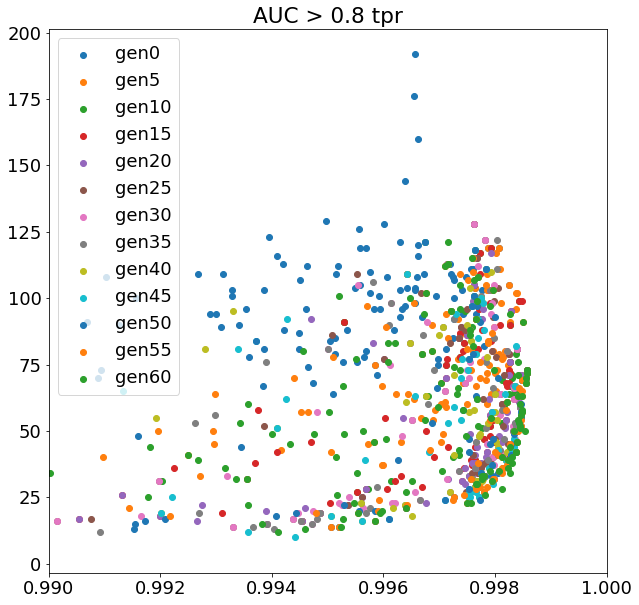

In [17]:
plt.figure(figsize=(10,10))
if 'auc' in name:
    coeff=(-1,1)
    title = 'AUC > 0.8 tpr'
    plt.xlim(0.99, 1)
else:
    coeff= (1,1)
    title= 'bkg eff at 0.99 signal efficiency'
plt.scatter(res.history[0].pop.get('F').T[0]*-1,res.history[0].pop.get('F').T[1], label = 'gen0')
for i, hist in enumerate(res.history):
    if (i+1)%5==0:
        plt.scatter(res.history[i].pop.get('F').T[0]*-1,res.history[i].pop.get('F').T[1], label = 'gen{}'.format(i+1))
plt.title('AUC > 0.8 tpr')
plt.legend()

import plotly.graph_objects as go
dimensions=[]

for ft in feats:
    tmp = dict(range=[0,maxbit[ft]],
              #constraintrange = [0,12],
              label= ft,
              values= result[ft])
    dimensions.append(tmp)
    
fig = go.Figure(data = 
               go.Parcoords(
                    line = dict(color = result['eff'],
                            colorscale = 'Bluered',
                            showscale =True,
                            cmin = 99.7,
                            cmax=result['eff'].max()
                               ),
                    dimensions = dimensions
                              
                              
                           )
               )
fig.show()
fig.write_image(savedir + '{}_par.png'.format(name))

In [18]:
bkg

'PU'

#order var by importance
result_sorted=result.reindex(result.mean().sort_values().index, axis=1)
import plotly.graph_objects as go
dimensions=[]
for ft in result_sorted.columns :
    if ft not in ['bkg_efficiency', 'number of bits']:
        tmp = dict(range=[0,12],
                  #constraintrange = [0,12],
                  label= ft,
                  values= result_sorted[ft])
        dimensions.append(tmp)

    fig = go.Figure(data = 
                   go.Parcoords(
                        line = dict(color = result_sorted['bkg_efficiency'],
                                colorscale = 'Bluered',
                                showscale =True,
                                cmin = 99.8,
                                cmax=result['bkg_efficiency'].max()
                                   ),
                        dimensions = dimensions


                               )
                   )
fig.show()
fig.write_image(savedir + '{}_par_sorted.png'.format(name))

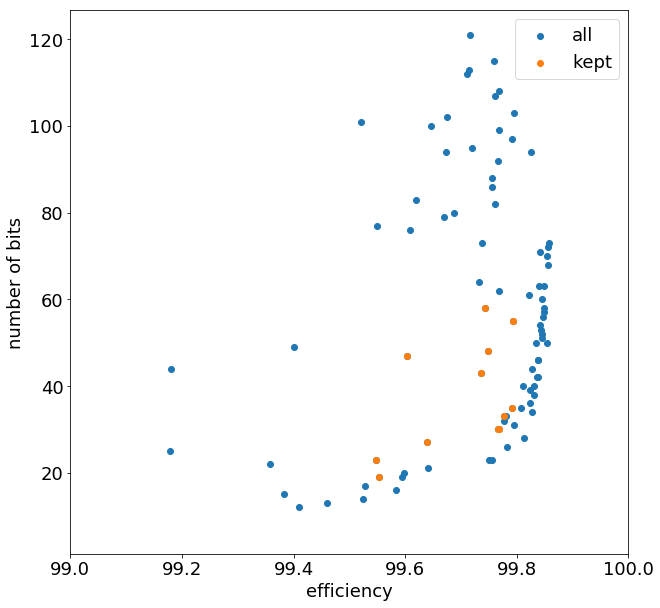

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(result['eff'],result['bits'],  label = 'all')
plt.scatter(result_cut['eff'],result_cut['bits'],  label = 'kept')
plt.xlabel('efficiency')
plt.ylabel('number of bits')
plt.xlim(99,100)

plt.legend()
plt.show()


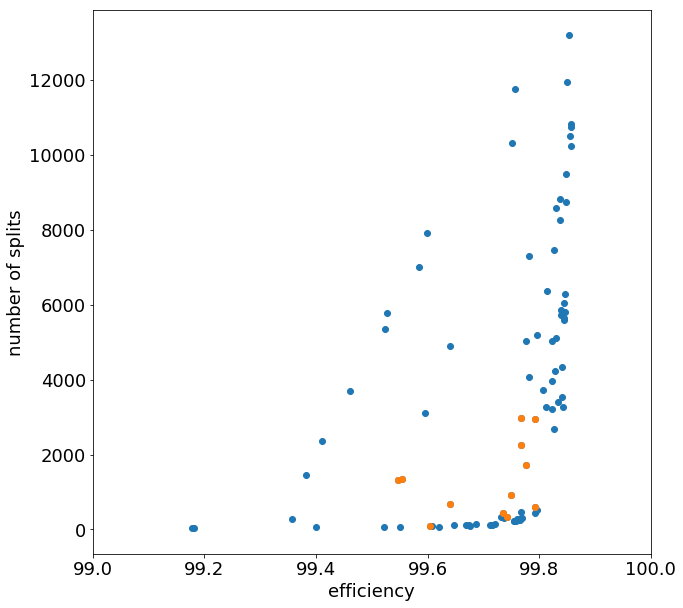

W0202 11:59:15.003238 139678379751232 legend.py:1289] No handles with labels found to put in legend.


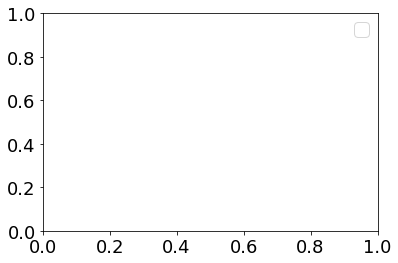

In [20]:

plt.figure(figsize=(10,10))





plt.scatter(result['eff'],result['splits'],  label = 'all')
plt.scatter(result_cut['eff'],result_cut['splits'],  label = 'kept')
plt.xlabel('efficiency')
plt.ylabel('number of splits')
plt.xlim(99,100)
plt.show()
plt.legend()

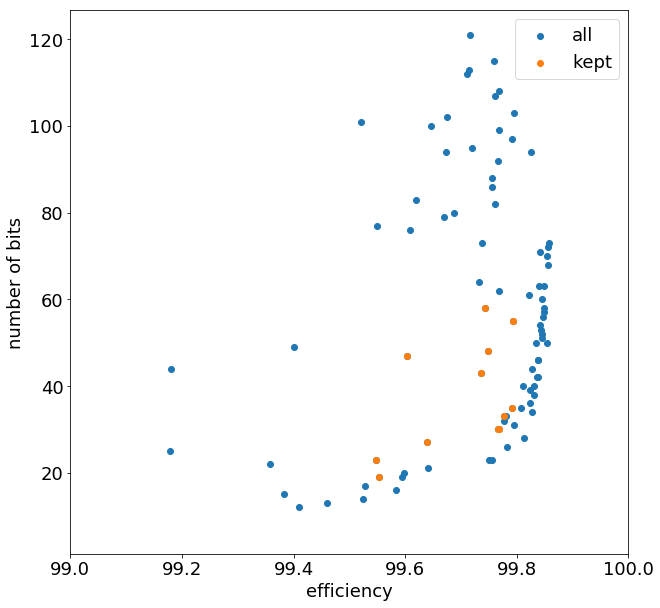

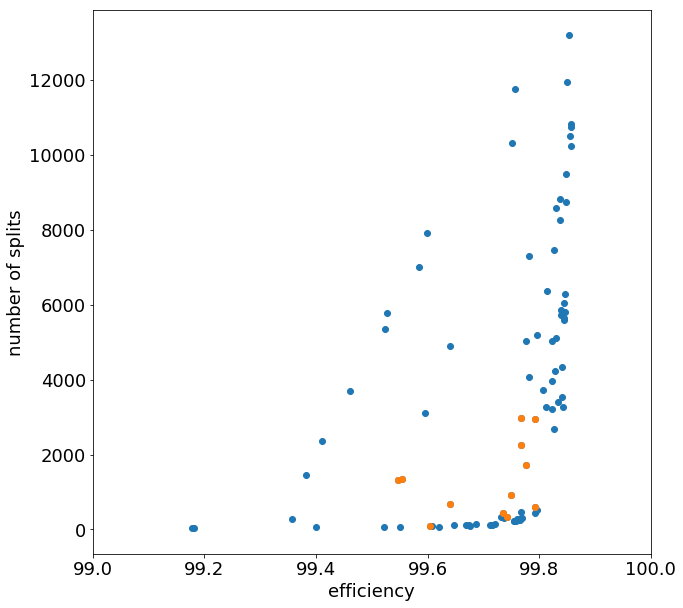

W0202 11:59:15.516884 139678379751232 legend.py:1289] No handles with labels found to put in legend.


'nlay=14\nresult_cut[\'ebm1\']= nlay/np.ceil(nlay/result_cut[\'ebm1\'])\nresult_cut[\'ebm1\']=result_cut[\'ebm1\'].astype(\'int\')\nif \'rev_ebm1\' in result_cut.columns:\n    result_cut[\'rev_ebm1\'/np.ceil(nlay/result_cut[\'rev_ebm1\'])\n    result_cut[\'rev_ebm1\']=result_cut[\'rev_ebm1\'].astype(\'int\')\n\nfor ft in result_cut.columns :\n    if ft not in [\'bkg_efficiency\', \'number of bits\']:\n        tmp = dict(range=[0,maxbit[ft]],\n                  #constraintrange = [0,12],\n                  label= ft,\n                  values= result_cut[ft])\n        dimensions.append(tmp)\n\n    fig = go.Figure(data = \n                   go.Parcoords(\n                        line = dict(color = result_cut[\'efficiency\'],\n                          colorscale=[(0.00, "green"),   (0.25, "green"),\n                                                     (0.25, "orange"), (0.5, "orange"),\n                                                     (0.5, "red"),  (0.75, "red"),\n                

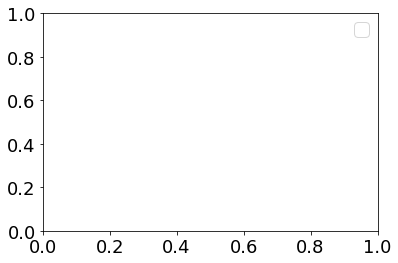

In [21]:
plt.ioff()
"""#plot par only with "turn"
if bkg == "QCD":
    auc_min= 99.54
    auc_max=99.87
    cmin=99.65
    cmax=99.87
    
elif bkg== "pions":
    auc_min= 99.4
    auc_max=99.83
    cmin=99.5
    cmax=99.83
    
elif bkg== "PU":
    auc_min= 99.5
    auc_max=99.8
    cmin=99.55
    cmax=99.85
result_cut = result_sorted[(result_sorted['bkg_efficiency']>auc_min) &(result_sorted['bkg_efficiency']<auc_max) ]
"""

plt.figure(figsize=(10,10))


plt.scatter(result['eff'],result['bits'],  label = 'all')
plt.scatter(result_cut['eff'],result_cut['bits'],  label = 'kept')
plt.xlabel('efficiency')
plt.ylabel('number of bits')
plt.xlim(99,100)

plt.legend()
plt.show()
plt.figure(figsize=(10,10))


plt.scatter(result['eff'],result['splits'],  label = 'all')
plt.scatter(result_cut['eff'],result_cut['splits'],  label = 'kept')
plt.xlabel('efficiency')
plt.ylabel('number of splits')
plt.xlim(99,100)
plt.show()
plt.legend()

import plotly.graph_objects as go
layout = go.Layout(
    autosize=False,
    width=480*16/9,
    height=480
)
dimensions=[]
# try to color result
"""nlay=14
result_cut['ebm1']= nlay/np.ceil(nlay/result_cut['ebm1'])
result_cut['ebm1']=result_cut['ebm1'].astype('int')
if 'rev_ebm1' in result_cut.columns:
    result_cut['rev_ebm1'/np.ceil(nlay/result_cut['rev_ebm1'])
    result_cut['rev_ebm1']=result_cut['rev_ebm1'].astype('int')

for ft in result_cut.columns :
    if ft not in ['bkg_efficiency', 'number of bits']:
        tmp = dict(range=[0,maxbit[ft]],
                  #constraintrange = [0,12],
                  label= ft,
                  values= result_cut[ft])
        dimensions.append(tmp)

    fig = go.Figure(data = 
                   go.Parcoords(
                        line = dict(color = result_cut['efficiency'],
                          colorscale=[(0.00, "green"),   (0.25, "green"),
                                                     (0.25, "orange"), (0.5, "orange"),
                                                     (0.5, "red"),  (0.75, "red"),
                                                     (0.75, "blue"),  (1, "blue")],

                                showscale =True,
                                cmin = cmin,
                                cmax=cmax
                                   ),
                        dimensions = dimensions


                               ),
                    layout=layout,
                   )
fig.show()"""
#fig.write_image(savedir + '{}_par_cut.png'.format(name))

In [22]:
bkg

'PU'

In [23]:
savedir

'/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/PU/'

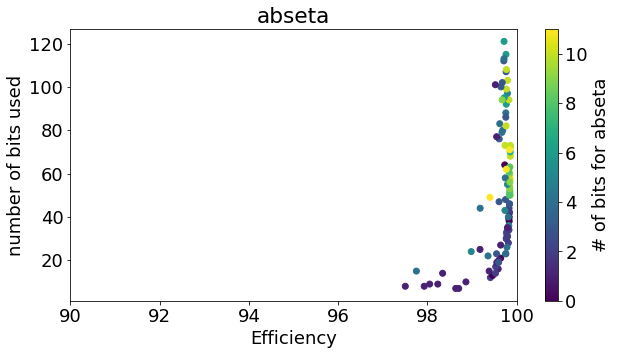

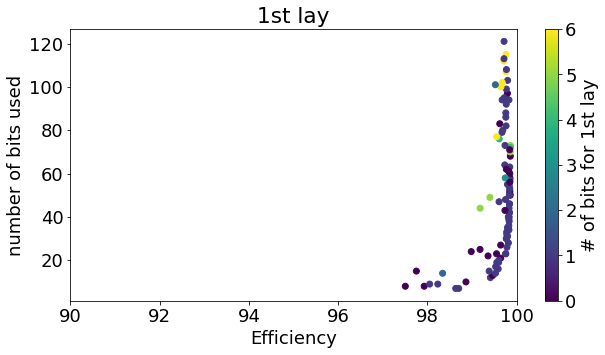

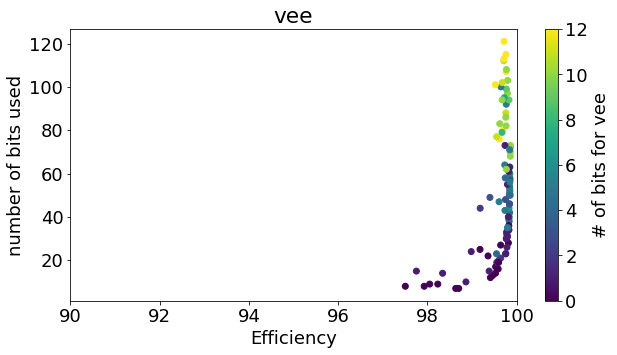

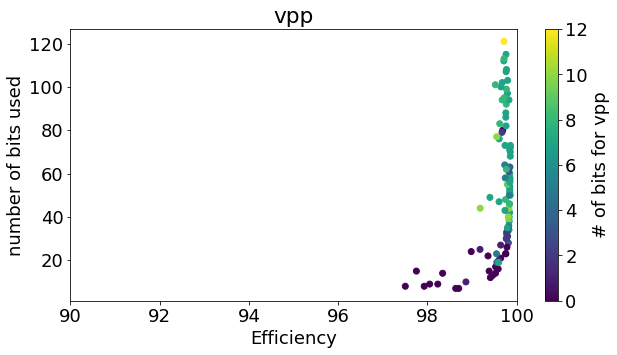

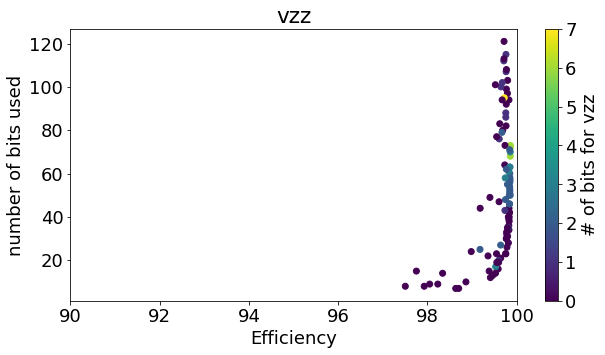

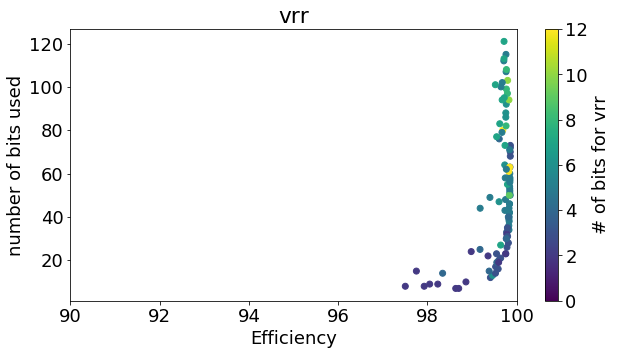

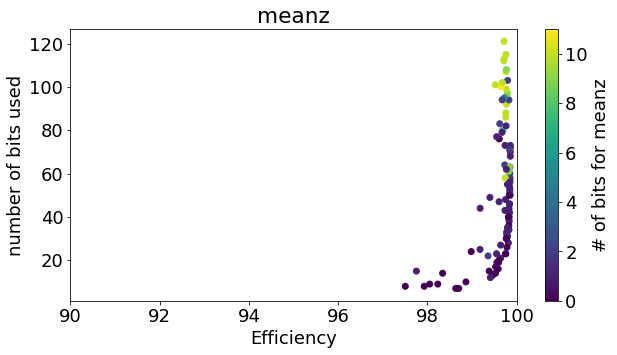

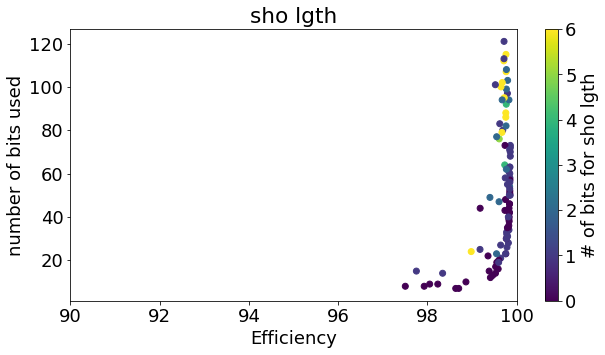

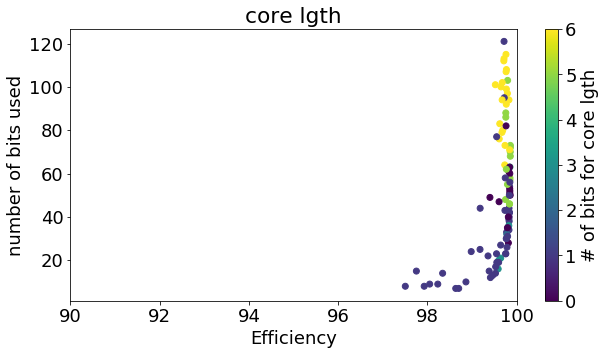

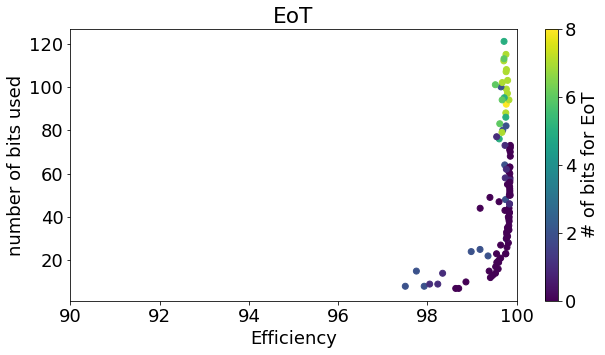

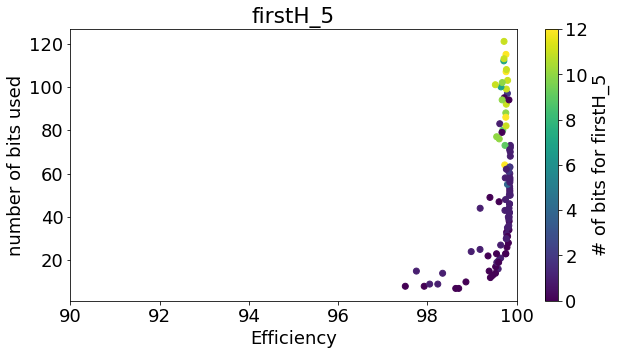

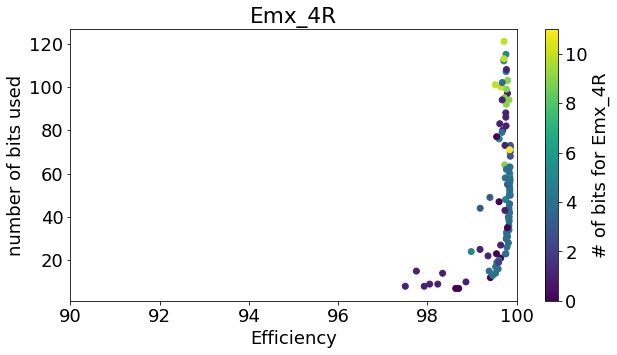

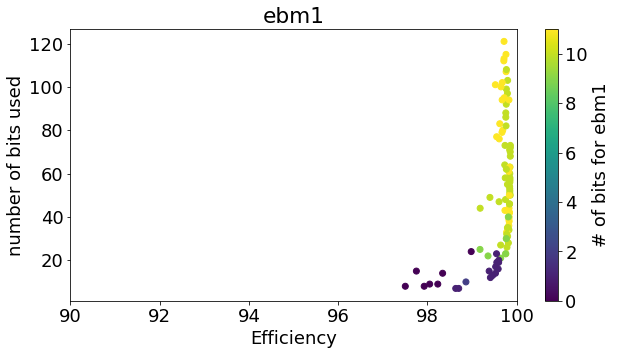

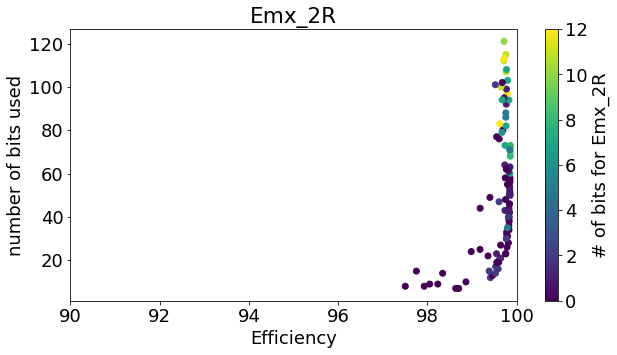

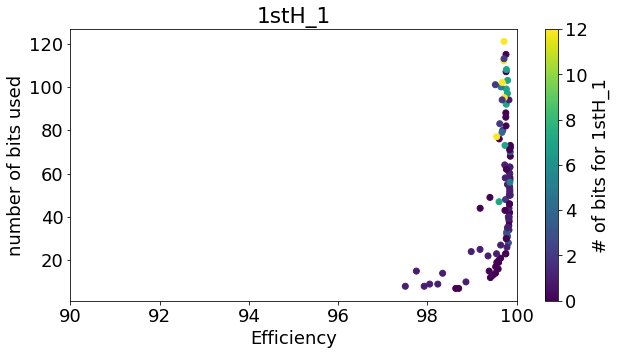

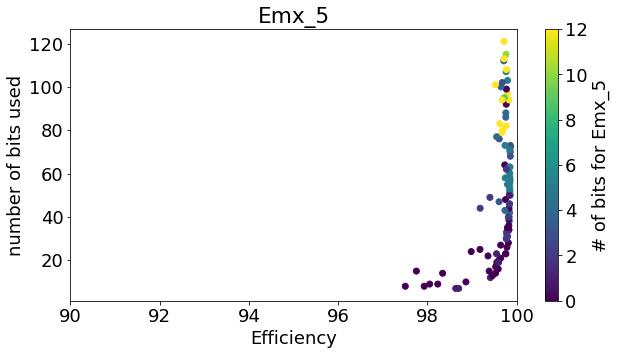

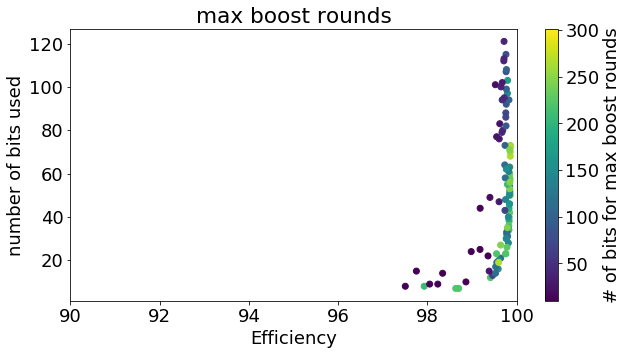

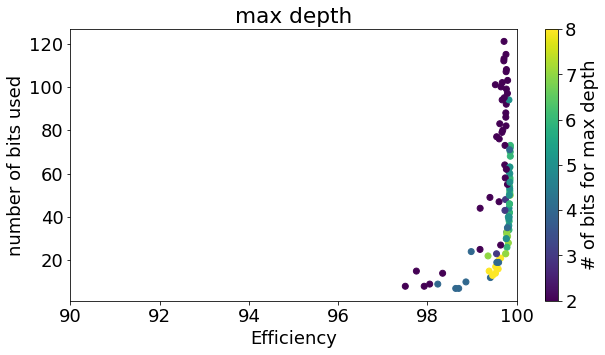

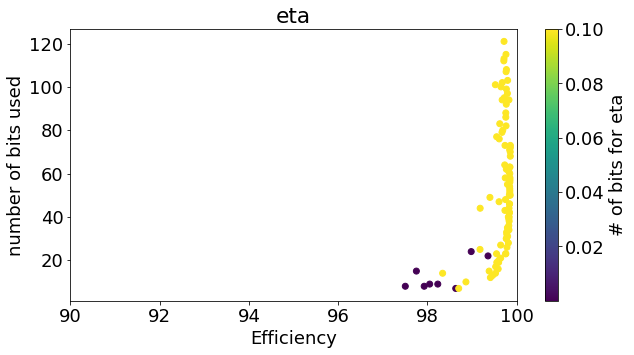

In [24]:
os.makedirs(savedir + 'feats', exist_ok=True)
for ft in feats:
    plt.figure(figsize=(10,5))
    plt.scatter(result['eff'].values, result['bits'], c= result[ft])
    plt.xlim(90,100)
    cbar=plt.colorbar()
    cbar.set_label('# of bits for {}'.format(ft))
    plt.xlabel('Efficiency')
    plt.ylabel('number of bits used')
    plt.title(ft)
    os.makedirs('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/'+ '/eff_vs_bits/{}'.format(bkg), exist_ok=True)
    plt.savefig('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/'+ '/eff_vs_bits/{}/{}'.format(bkg,ft))
    

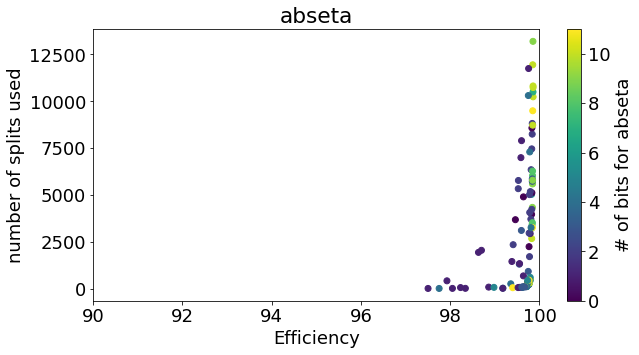

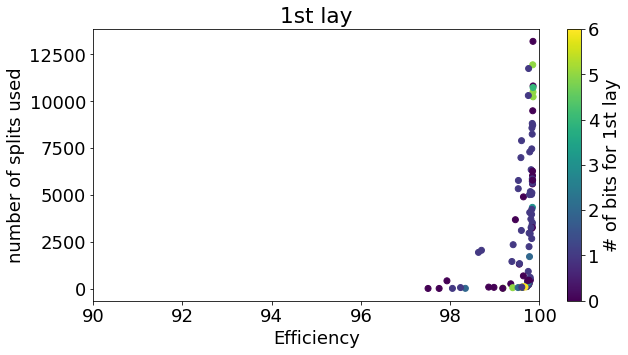

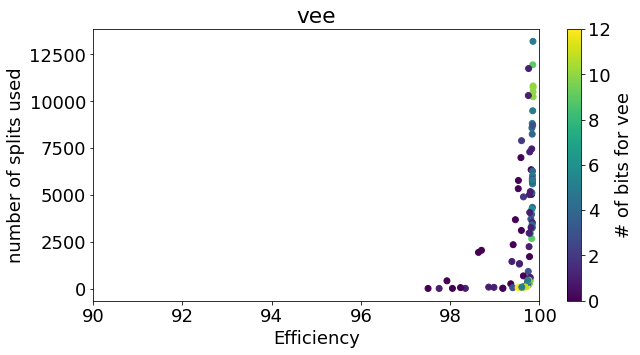

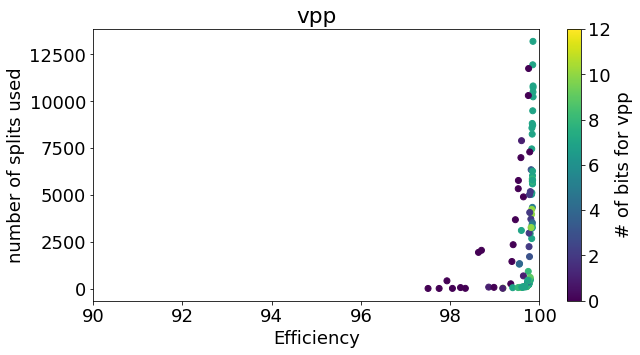

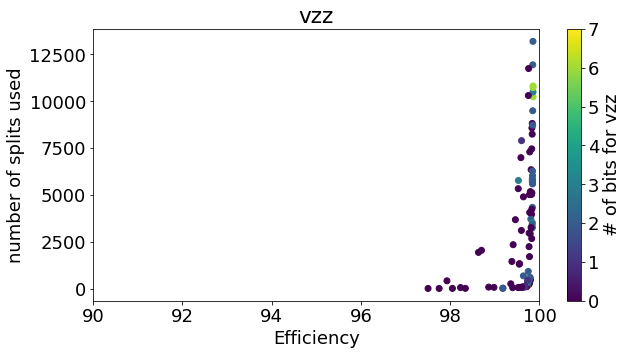

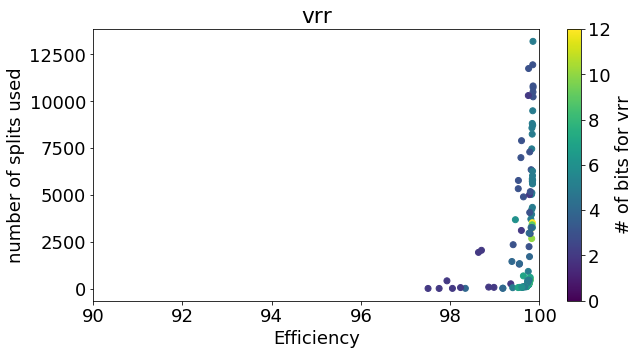

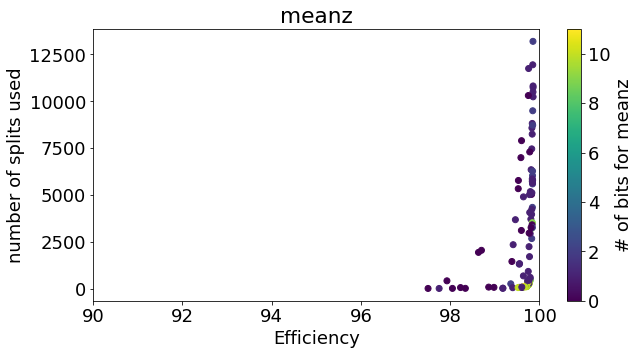

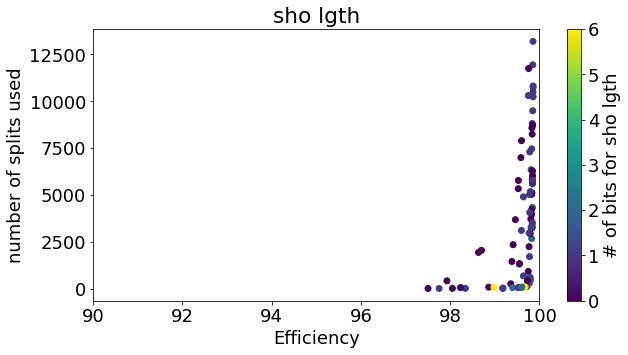

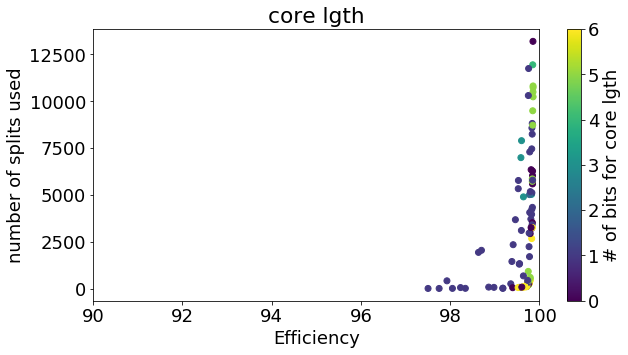

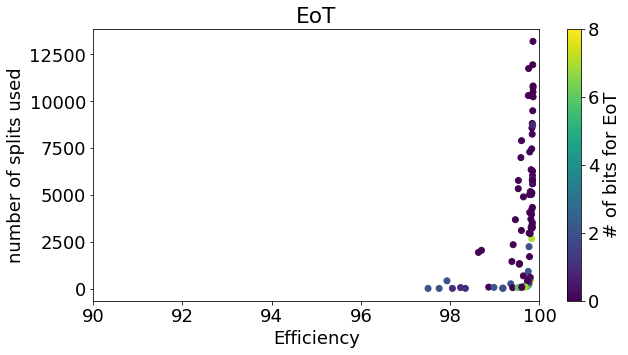

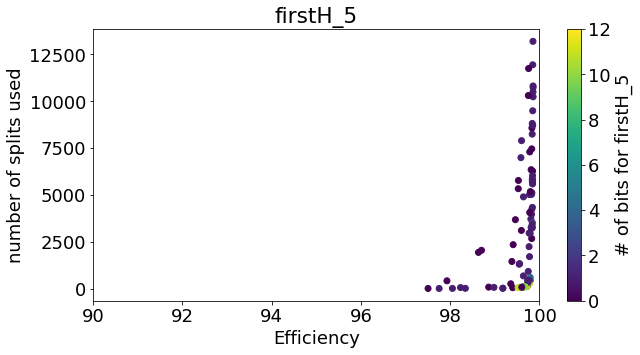

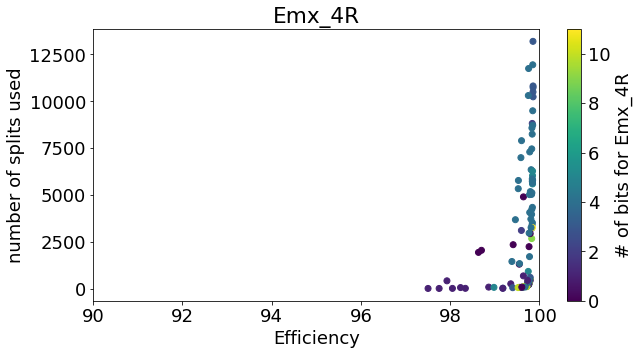

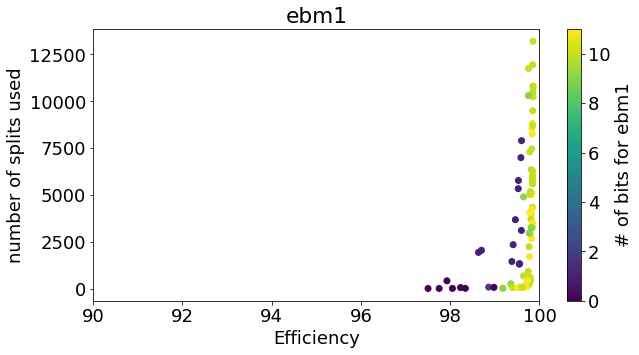

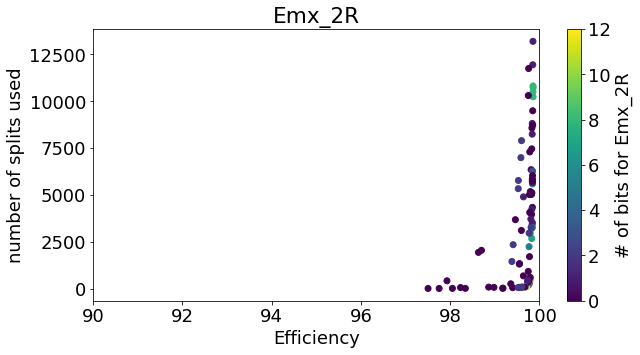

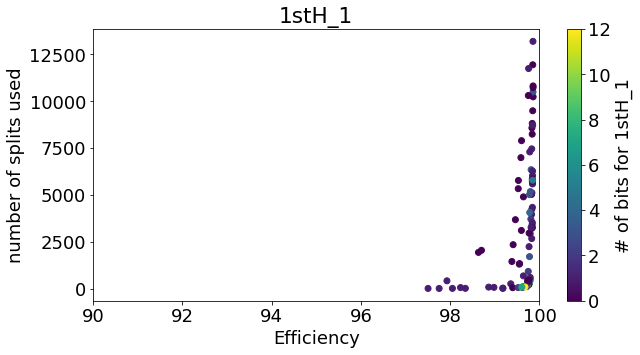

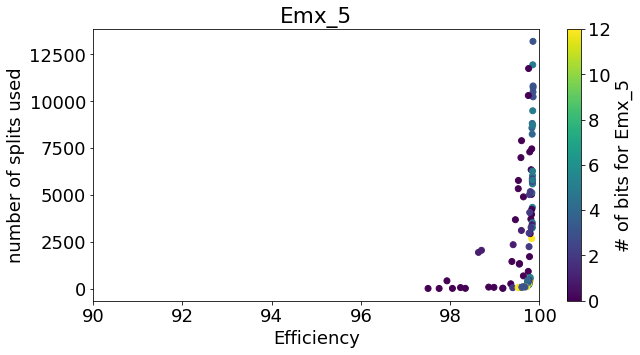

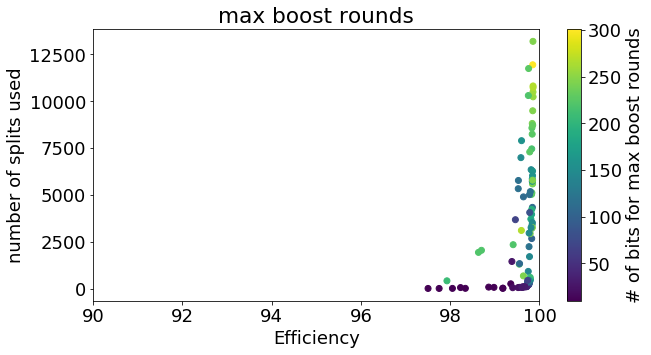

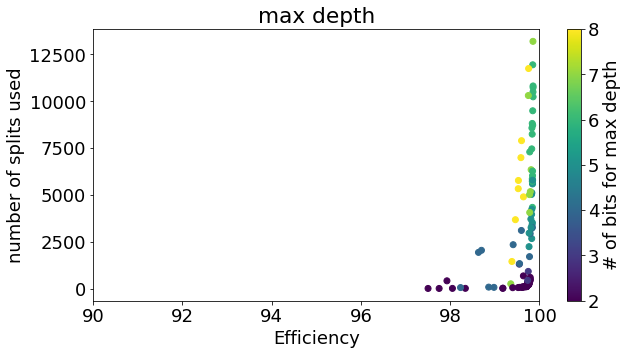

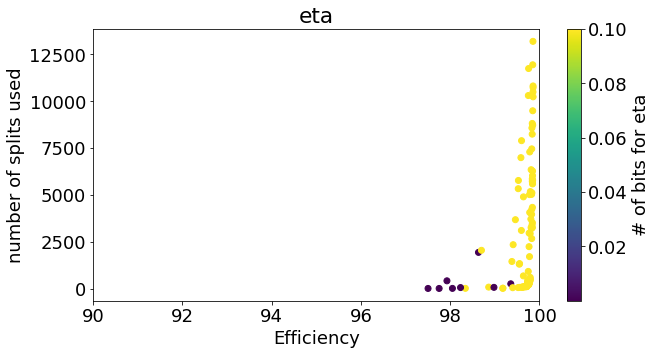

In [25]:
os.makedirs(savedir + 'feats', exist_ok=True)
for ft in feats:
    plt.figure(figsize=(10,5))
    plt.scatter(result['eff'].values, result['splits'], c= result[ft], alpha=1)
    plt.xlim(90,100)
    cbar=plt.colorbar()
    cbar.set_label('# of bits for {}'.format(ft))
    plt.xlabel('Efficiency')
    plt.ylabel('number of splits used')
    plt.title(ft)
    os.makedirs('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/'+ '/eff_vs_splits/{}'.format(bkg), exist_ok=True)
    plt.savefig('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/'+ '/eff_vs_splits/{}/{}'.format(bkg,ft))
    

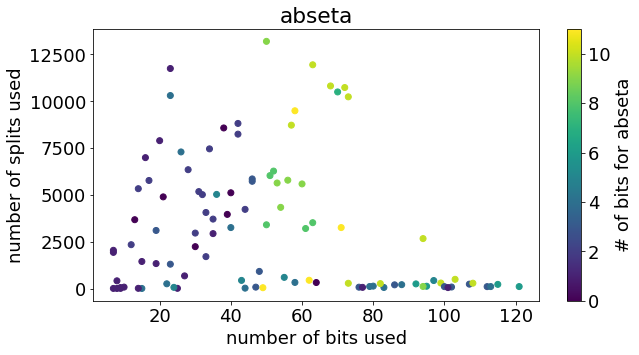

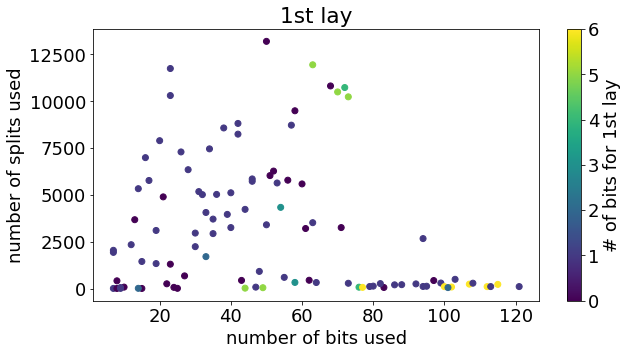

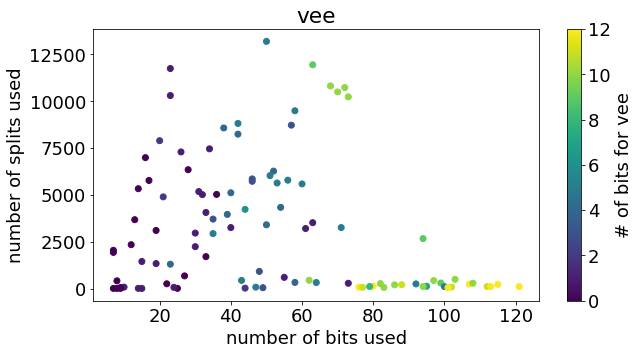

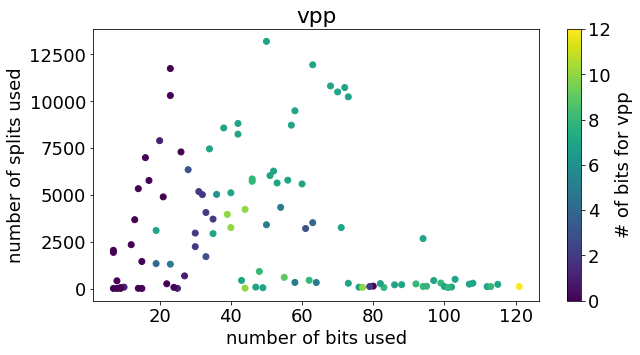

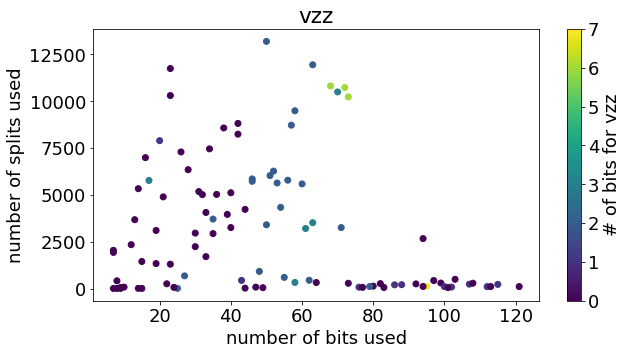

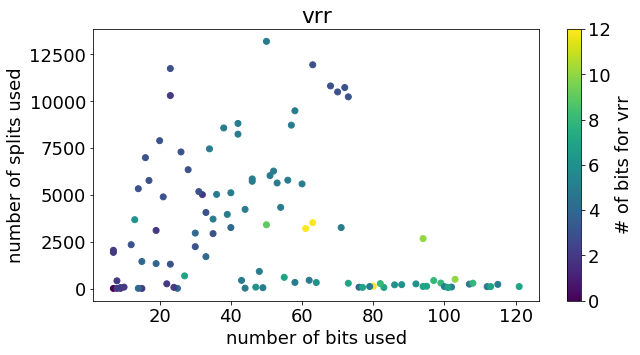

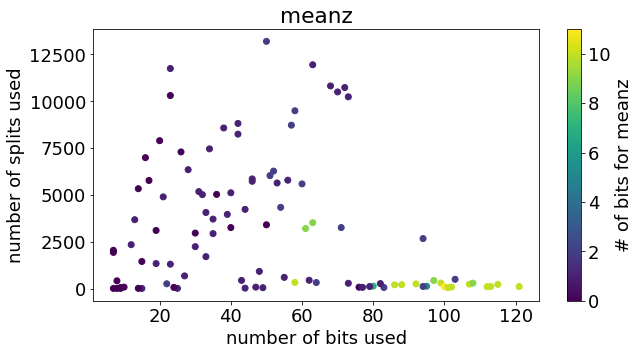

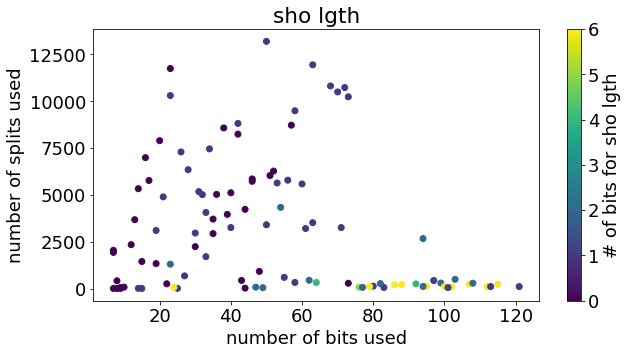

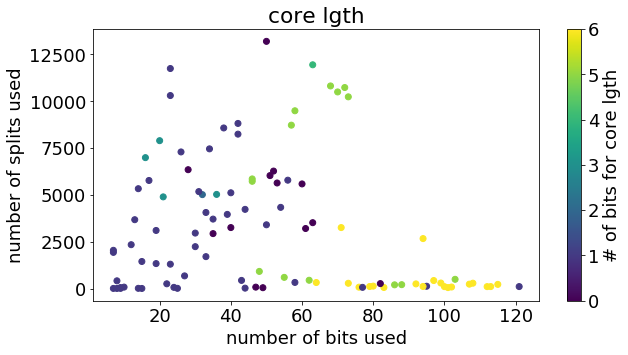

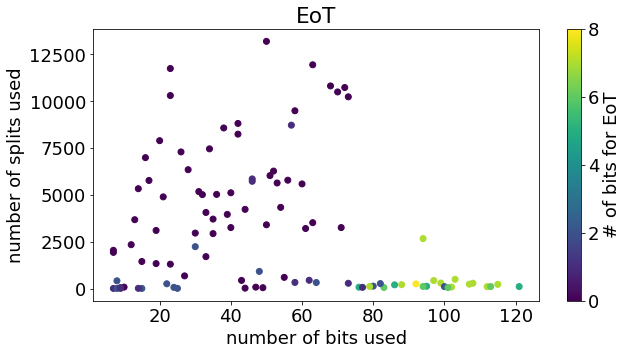

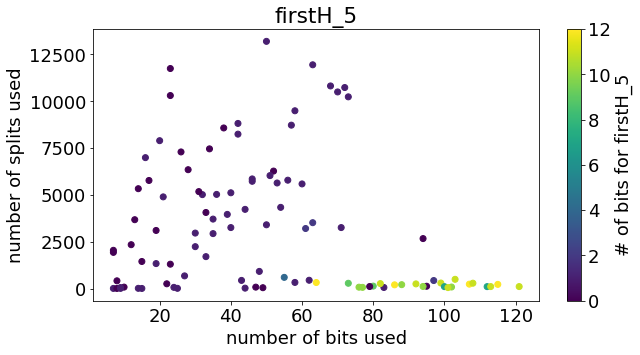

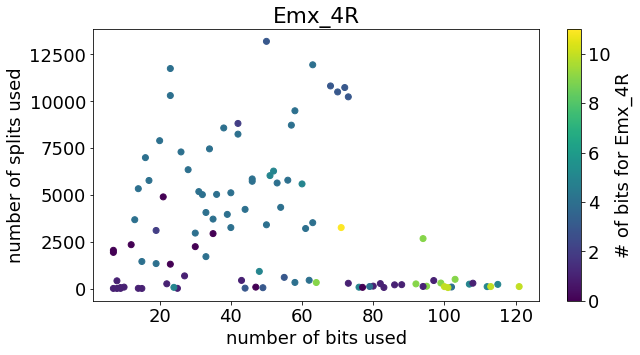

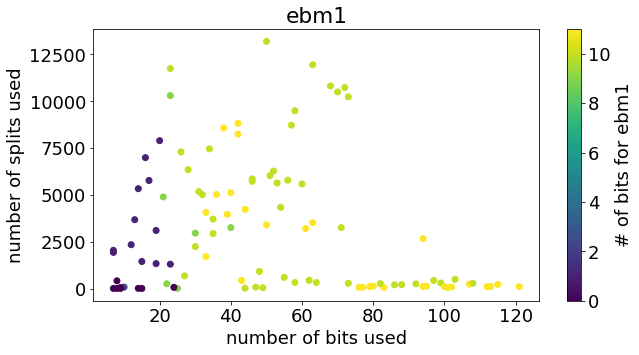

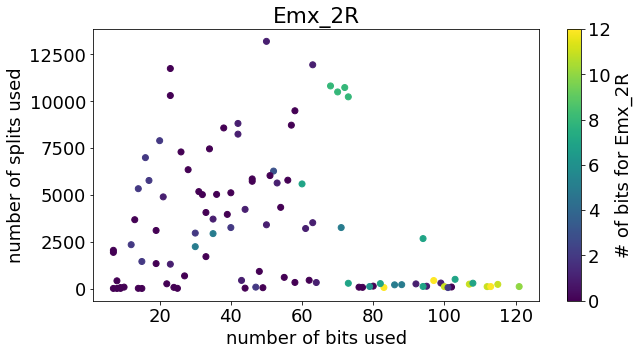

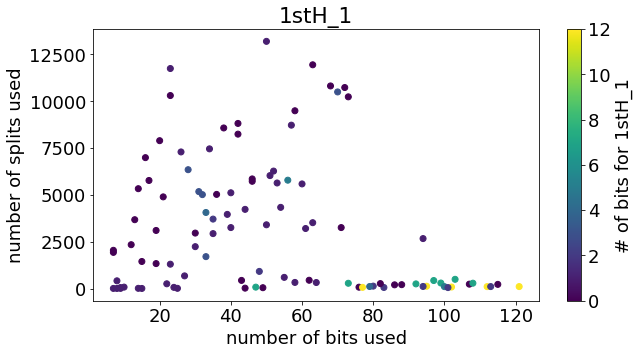

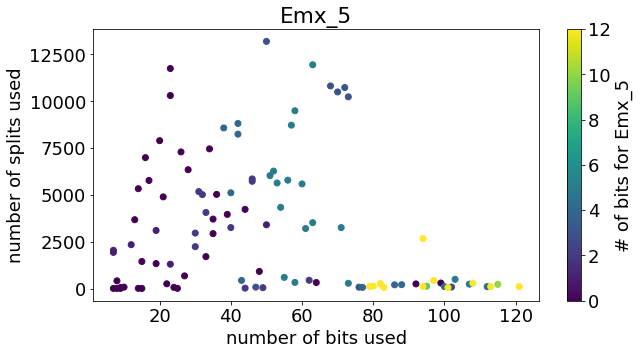

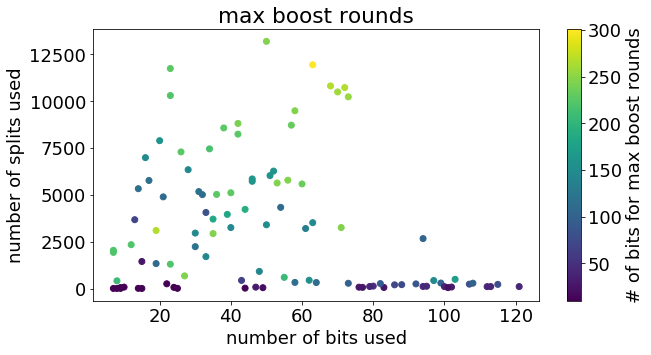

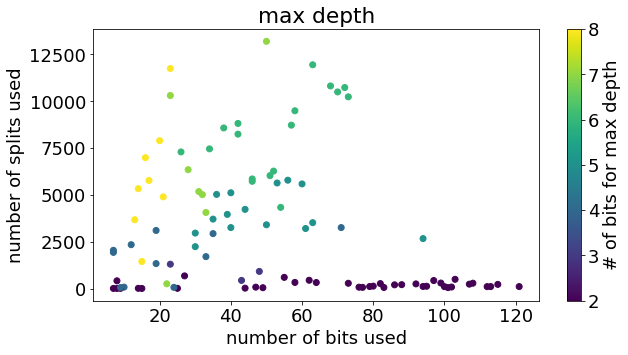

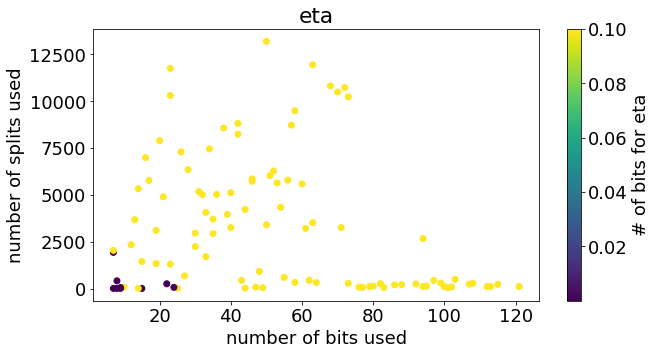

In [26]:
os.makedirs(savedir + 'feats', exist_ok=True)
for ft in feats:
    plt.figure(figsize=(10,5))
    plt.scatter(result['bits'].values, result['splits'], c= result[ft], alpha=1)
    #plt.xlim(90,100)
    cbar=plt.colorbar()
    cbar.set_label('# of bits for {}'.format(ft))
    plt.xlabel('number of bits used')
    plt.ylabel('number of splits used')
    plt.title(ft)
    os.makedirs('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/'+ '/bits_vs_splits/{}'.format(bkg), exist_ok=True)
    plt.savefig('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/'+ '/bits_vs_splits/{}/{}'.format(bkg,ft))
    

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  7., 90.]),
 array([ 90.        ,  91.11111111,  92.22222222,  93.33333333,
         94.44444444,  95.55555556,  96.66666667,  97.77777778,
         98.88888889, 100.        ]),
 <a list of 9 Patch objects>)

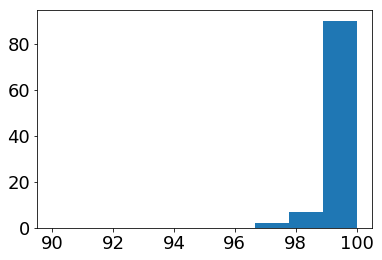

In [27]:
plt.hist(result['eff'], bins=np.linspace(90,100,10))

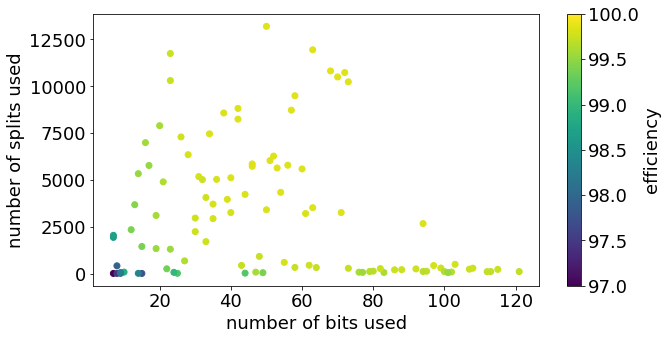

In [28]:
os.makedirs(savedir + 'feats', exist_ok=True)

plt.figure(figsize=(10,5))
plt.scatter(result['bits'].values, result['splits'], c= result['eff'], alpha=1)
#plt.xlim(90,100)
plt.clim(97,100)
cbar=plt.colorbar()
cbar.set_label('efficiency')
plt.xlabel('number of bits used')
plt.ylabel('number of splits used')
#plt.title(ft)
os.makedirs('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/'+ '/bits_vs_splits/{}'.format(bkg), exist_ok=True)
plt.savefig('/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/moo/'+ '{}_eff_vs _complexity.png'.format(bkg,ft))

In [29]:
bkg

'PU'

([<matplotlib.axis.XTick at 0x7f07278b77b8>,
 <a list of 5 Text xticklabel objects>)

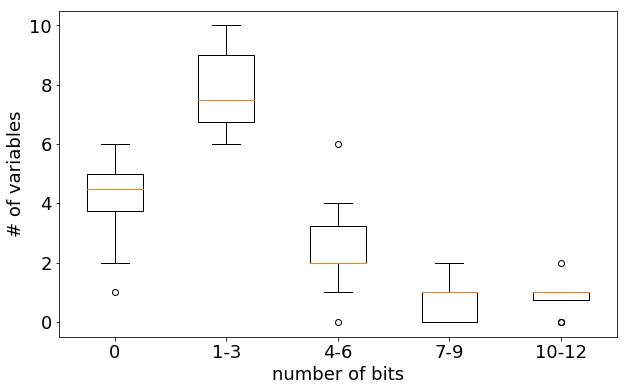

In [30]:
#plot hist nb per variable /n var
features= [col for col in result_cut.columns if col not in ['eff', 'bits', 'splits', 'max boost rounds', 'max depth', 'eta', 'n_kept']]
#bin number of bits
bins=[0,0.1,3.1,6.1,9.1,12]
hist=pd.DataFrame(columns=["0","1-3","4-6","7-9","10-12"] )
for i in range(0,len(result_cut)):
    hist=hist.append(pd.Series(np.histogram(result_cut[features].iloc[i], bins=bins)[0],index = hist.columns),ignore_index=True)
plt.figure(figsize=(10,6))

plt.boxplot(hist.T)
plt.ylabel('# of variables')
plt.xlabel('number of bits')

plt.xticks([1,2,3,4,5], ['0', '1-3', '4-6', '7-9', '10-12'],)

In [31]:
hist

0 1-3 4-6 7-9 10-12
0   5   9   2   0     0
1   3   8   3   1     1
2   4  10   1   0     1
3   5   8   2   0     1
4   6   7   3   0     0
5   2   7   4   2     1
6   1   7   6   0     2
7   6   6   2   1     1
8   4   9   2   1     0
9   5   9   0   1     1
10  4   6   4   1     1
11  5   6   2   2     1

In [32]:
np.histogram(result_cut.iloc[9], bins=bins)[0]

array([ 5, 11,  0,  1,  2])

In [33]:
bins

[0, 0.1, 3.1, 6.1, 9.1, 12]

In [34]:
result_cut.iloc[9]

EoT                   0.00
sho lgth              1.00
vzz                   2.00
1st lay               0.00
firstH_5              1.00
Emx_2R                0.00
core lgth             1.00
1stH_1                1.00
meanz                 1.00
Emx_5                 0.00
Emx_4R                1.00
abseta                1.00
vee                   0.00
vrr                   7.00
vpp                   1.00
ebm1                 10.00
max boost rounds    245.00
max depth             2.00
eta                   0.10
n_kept               11.00
bits                 27.00
splits              690.00
eff                  99.64
Name: 88, dtype: float64

In [35]:
# try to color result

In [36]:
# try to represent in one plot the range of parameters used against each bkg
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name
signal='elec'

savedir = workdir + '/moo/'
#os.makedirs(savedir, exist_ok=True)

name = '40gen_diag_auc_mut10_3d.pkl'
pions_df=pd.read_csv(savedir+'pions/{}_lastgen.csv'.format(name))
PU_df=pd.read_csv(savedir+'PU/{}_lastgen.csv'.format(name))
QCD_df=pd.read_csv(savedir+'QCD/{}_lastgen.csv'.format(name))

auc_min = 99.5
auc_max=99.9
bits_min= 0
bits_max = 60
splits_min= 0
splits_max= 3000

PU_cut=PU_df[(PU_df['eff']<auc_max) & (PU_df['eff']>= auc_min) & (PU_df['bits']>= bits_min) & 
                   (PU_df['bits']<bits_max)& (PU_df['splits']>=splits_min) & (PU_df['splits']<splits_max)]
auc_min = 99.6
auc_max=99.9
bits_min= 0
bits_max = 35
splits_min= 0
splits_max= 600
pions_cut=pions_df[(pions_df['eff']<auc_max) & (pions_df['eff']>= auc_min) & (pions_df['bits']>= bits_min) & 
                   (pions_df['bits']<bits_max)& (pions_df['splits']>=splits_min) & (pions_df['splits']<splits_max)]
auc_min = 99.7
auc_max=99.9
bits_min= 0
bits_max = 55
splits_min= 0
splits_max= 5000
QCD_cut=QCD_df[(QCD_df['eff']<auc_max) & (QCD_df['eff']>= auc_min) & (QCD_df['bits']>= bits_min) & 
                   (QCD_df['bits']<bits_max)& (QCD_df['splits']>=splits_min) & (QCD_df['splits']<splits_max)]


In [37]:
common=list(set(PU_cut.columns).intersection(set(pions_cut)).intersection(set(QCD_cut)))


In [38]:
common

['sho lgth',
 'max depth',
 'Emx_4R',
 'vee',
 'vrr',
 'meanz',
 'abseta',
 '1st lay',
 'ebm1',
 'eta',
 'vzz',
 'Unnamed: 0',
 'Emx_5',
 'n_kept',
 'bits',
 'vpp',
 'eff',
 'core lgth',
 'splits',
 'EoT',
 'max boost rounds']

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



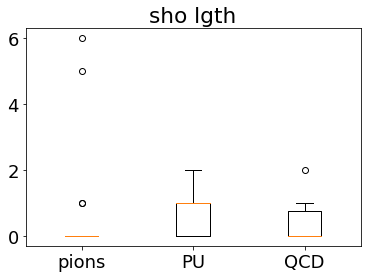

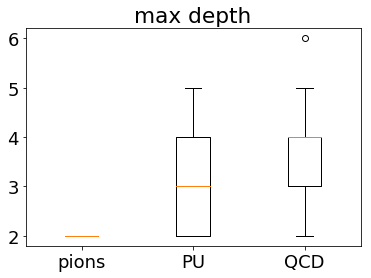

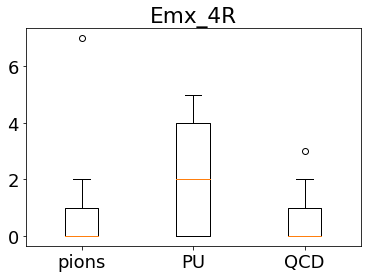

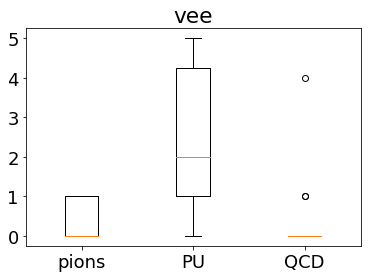

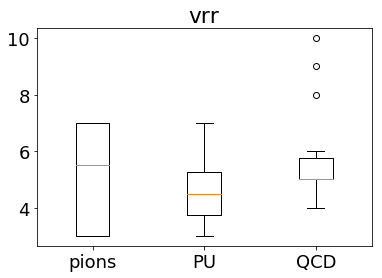

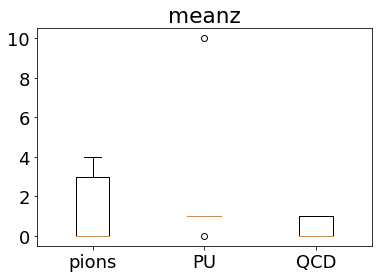

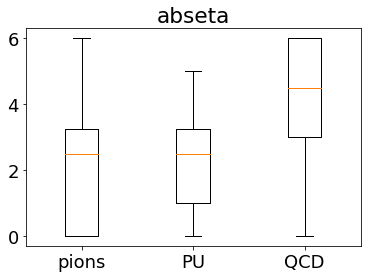

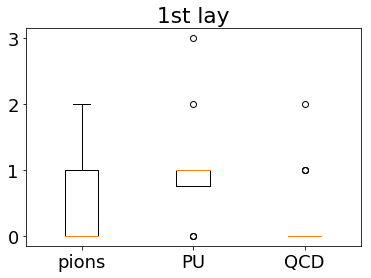

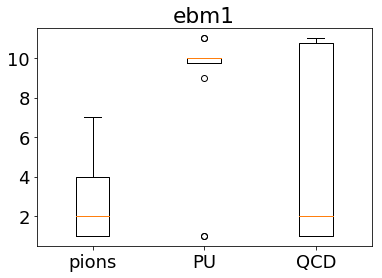

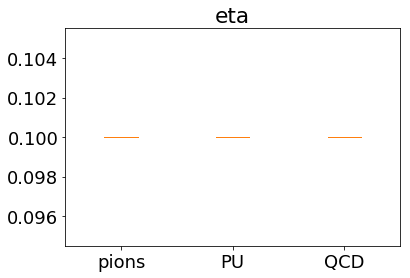

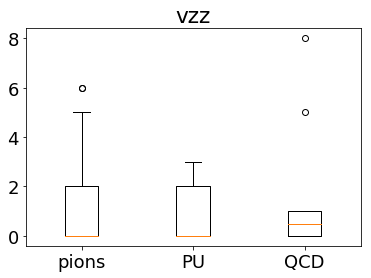

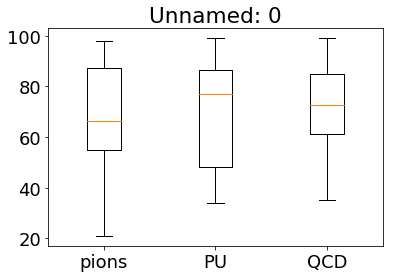

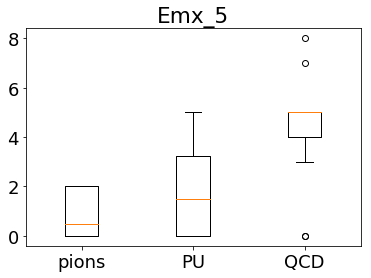

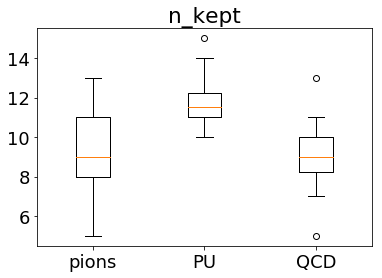

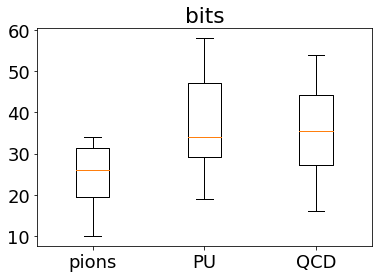

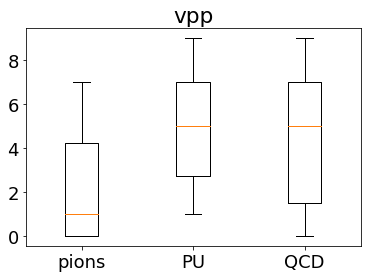

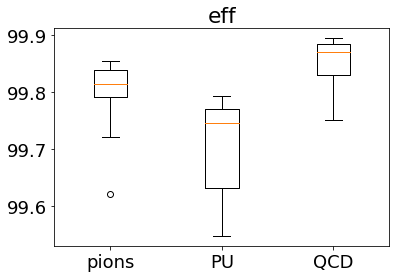

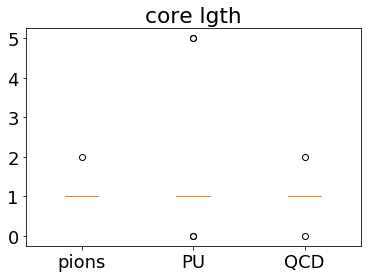

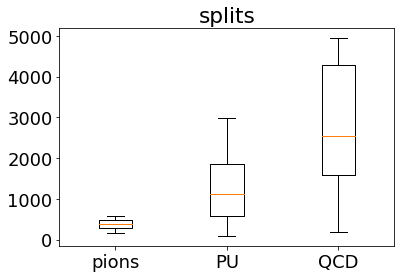

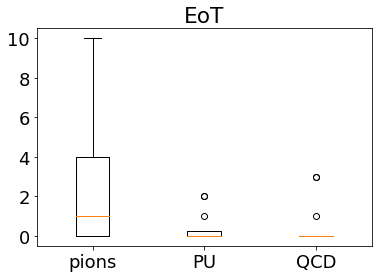

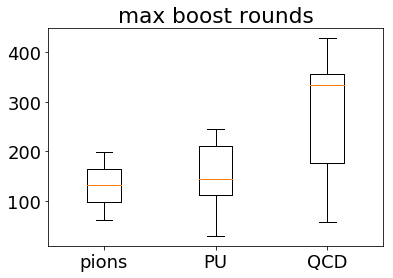

In [39]:
for var in common:
    plt.figure()
    plt.boxplot([pions_cut[var], PU_cut[var], QCD_cut[var]])
    plt.xticks([1,2,3], ['pions', 'PU', 'QCD'])
    plt.title(var)
    


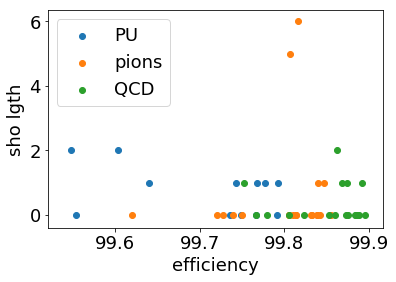

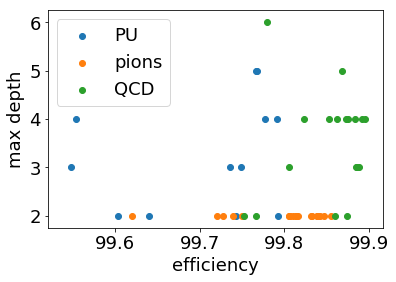

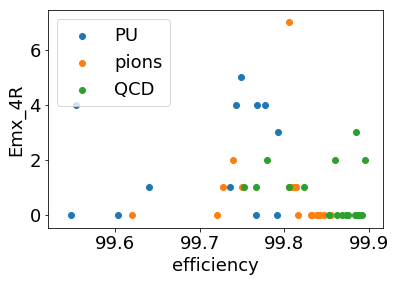

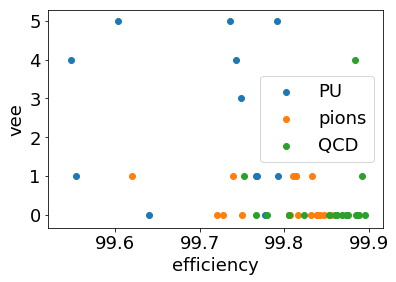

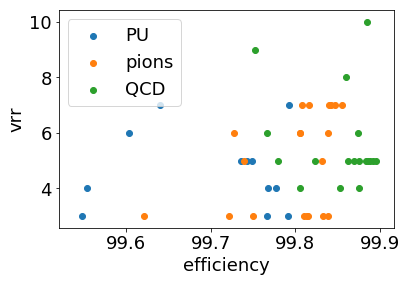

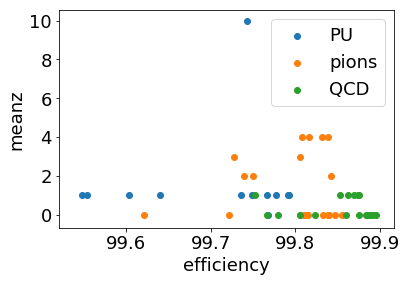

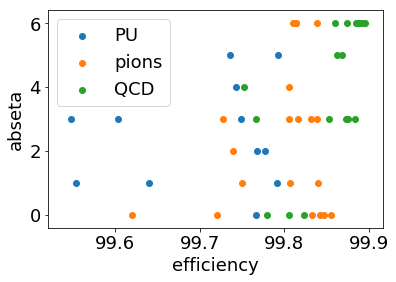

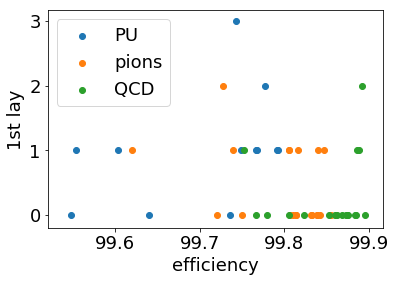

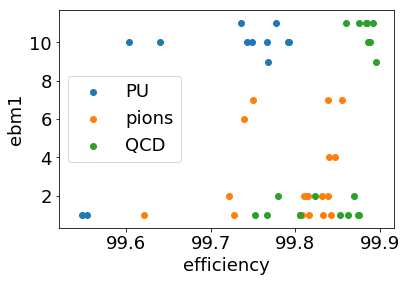

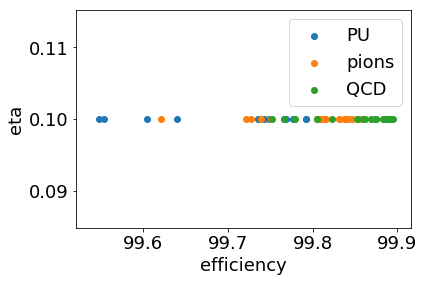

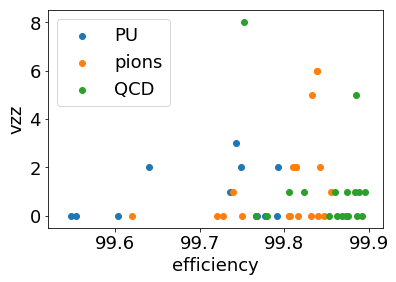

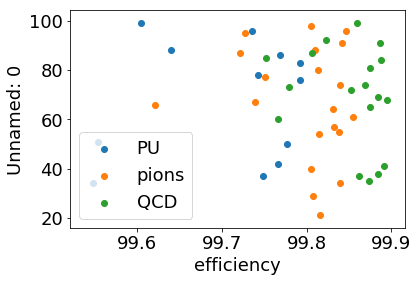

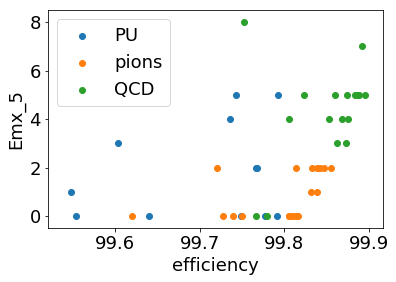

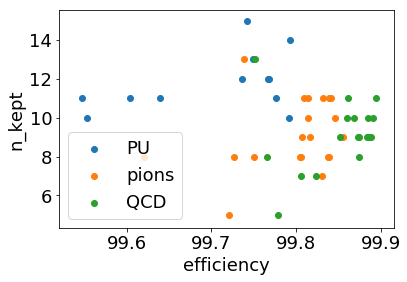

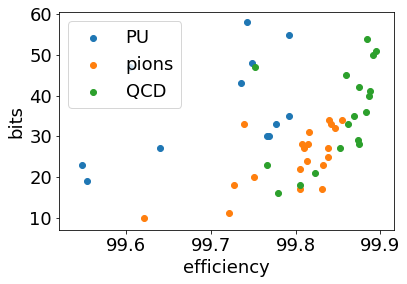

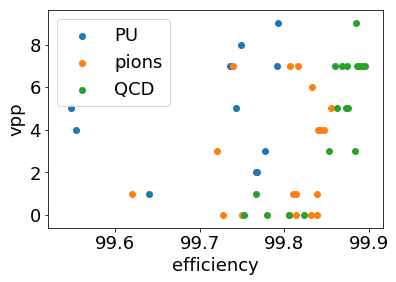

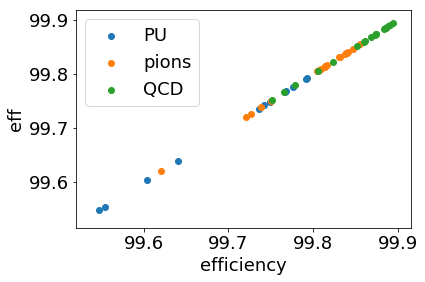

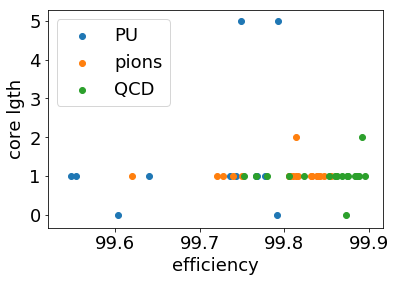

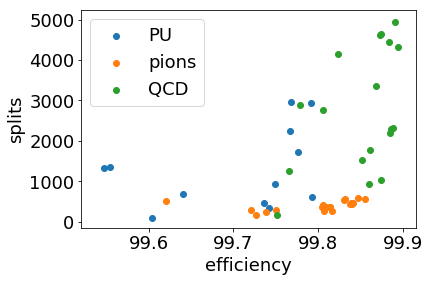

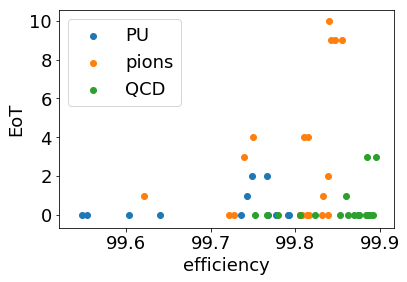

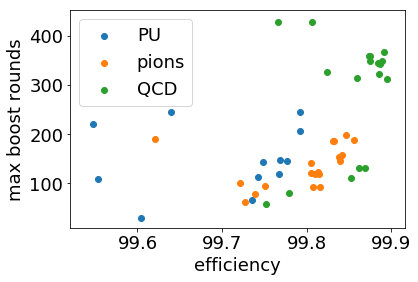

In [40]:
for var in common:
    plt.figure()
    plt.scatter( PU_cut['eff'],PU_cut[var], label='PU')
    plt.scatter(pions_cut['eff'],pions_cut[var],  label='pions')
    plt.scatter(QCD_cut['eff'],QCD_cut[var],  label='QCD')
    plt.legend()
    plt.xlabel('efficiency')
    plt.ylabel(var)